In this notebook, we apply GMM-MI to a a simple bivariate Gaussian distribution, and transform the Y variable with a quadratic function. We repeat the estimate varying the number of available samples to fit, showing that GMM-MI is unbiased in the limit of large number of samples. Even though a square transformation is not invertible in principle, it is for the range of data we consider here, so that invariance should be expected. GMM-MI shows good performance overall.

### Import packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical
from gmm_mi.utils.transformations import nonlinear_transformation
from gmm_mi.utils.plotting import violin_plots

### Define the true model (a simple bivariate Gaussian) and estimate its MI

In [2]:
n_components = 1
weights = np.array([1.])
means = np.zeros((1, 2))
C0 = [[1, 0.6], [0.6, 1]] # correlation is fixed to 0.6
covariances = np.array([C0])
analytic = calculate_MI_D1_analytical(covariances[0])

### Define transformations and plot typical data

True MI: 0.223 nats


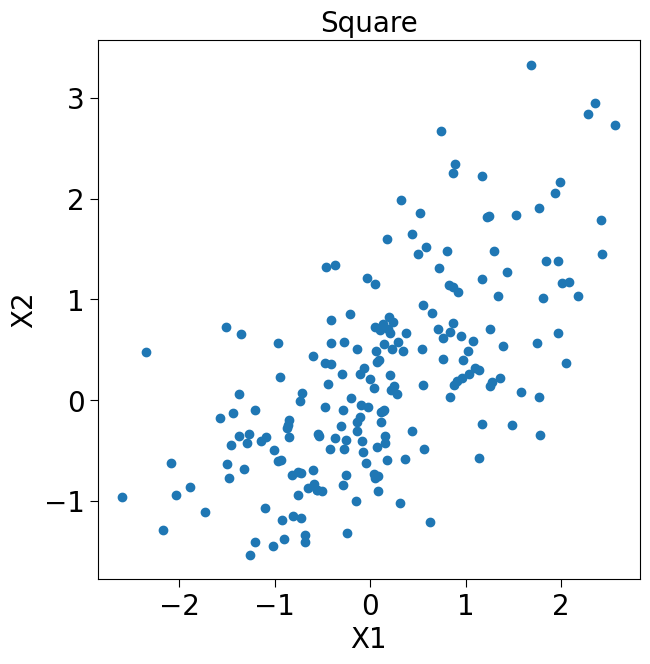

In [3]:
transformation = 'square'
print(f'True MI: {analytic:.3f} nats')
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
scatter_data = nonlinear_transformation(GMM(n_components=n_components, weights_init=weights, 
                              means_init=means, covariances_init=covariances).sample(200)[0], 
                                        transformation=transformation)
ax.scatter(scatter_data[:, 0], scatter_data[:, 1], label='Input data')
ax.tick_params(axis='both', which='both', labelsize=20, size=6)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_title(f'{transformation.capitalize()}', fontsize=20);

### Repeat the estimates on 500 independent realisations

In [4]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5, reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=5, n_folds=3)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100)

In [5]:
N_values = [200, 2000, 20000]
random_states = 500

for N in N_values:
    results_file = f'./results/MI_{transformation}_{random_states}_{N}.npy'

    if os.path.isfile(results_file):
        print('Not running this cell, since results file already exists. '
              'Loading pre-computed results...')
        all_MI_estimates = np.load(results_file)
    else:
        print(f'Estimating MI, and saving results...')
        all_MI_estimates = np.zeros((random_states, 2))

        for r in range(random_states):
            # create different realisation of ground truth; note the different random_state each time
            X = GMM(n_components=n_components, weights_init=weights, 
                              means_init=means, covariances_init=covariances, 
                              random_state=r).sample(N)[0]  
            X = nonlinear_transformation(X, transformation=transformation)

            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params)
            MI_mean, MI_std = mi_estimator.fit_predict(X, mi_dist_params=mi_dist_params)   

            all_MI_estimates[r, 0] = MI_mean
            all_MI_estimates[r, 1] = MI_std

            np.save(results_file, all_MI_estimates)
    print(N)

Not running this cell, since results file already exists. Loading pre-computed results...
200
Not running this cell, since results file already exists. Loading pre-computed results...
2000
Not running this cell, since results file already exists. Loading pre-computed results...
20000


### Repeat with KSG

In [6]:
from sklearn.feature_selection import mutual_info_regression
n_neighbors = 1 # keep minimum bias    

for N in N_values:
    results_file = f'./results/MI_{transformation}_{random_states}_{N}_ksg.npy'

    if os.path.isfile(results_file):
        print('Not running this cell, since results file already exists. '
              'Loading pre-computed results...')
        knn_estimates = np.load(results_file)
    else:
        print(f'Estimating MI, and saving results...')
        knn_estimates = np.zeros((random_states))

        for r in range(random_states):
            # create different realisation of ground truth; note the different random_state each time
            X = GMM(n_components=n_components, weights_init=weights, 
                              means_init=means, covariances_init=covariances, 
                              random_state=r).sample(N)[0]  
            X = nonlinear_transformation(X, transformation=transformation)
            
            knn_estimates[r] = mutual_info_regression(X[:, 0].reshape(-1, 1), X[:, 1], 
                                                n_neighbors=n_neighbors)

            np.save(results_file, knn_estimates)
    print(N)

Not running this cell, since results file already exists. Loading pre-computed results...
200
Not running this cell, since results file already exists. Loading pre-computed results...
2000
Not running this cell, since results file already exists. Loading pre-computed results...
20000


### Plot the results

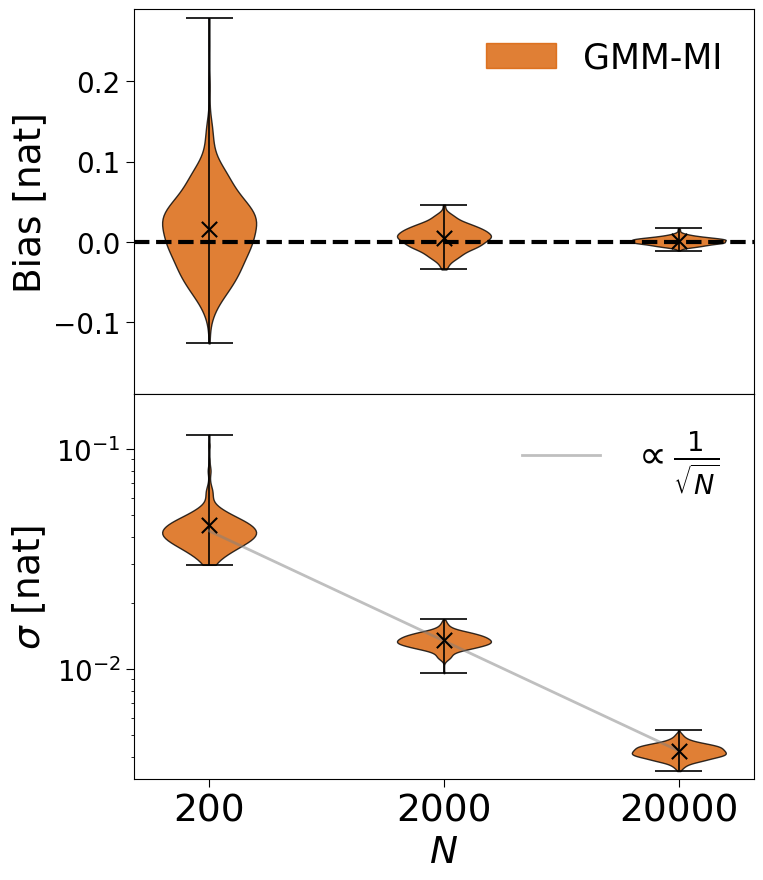

In [7]:
y_values = np.zeros((len(N_values), 500))
std_values = np.zeros((len(N_values), 500))

for i, N in enumerate(N_values):
    MI_file = np.load(f'./results/MI_{transformation}_{random_states}_{N}.npy')
    y_values[i] = MI_file[:, 0]-analytic 
    std_values[i] = MI_file[:, 1]
    
violin_plots(y_values, std_values, 
             transformation=transformation, N_values=N_values)

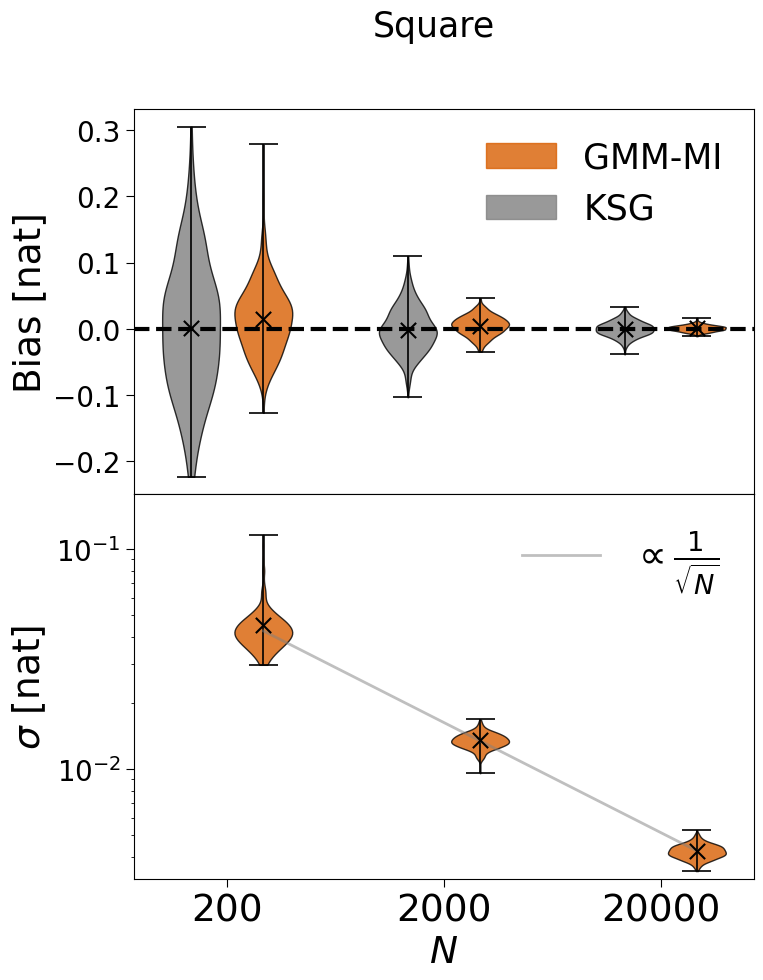

In [8]:
# compare results to KSG
ksg_values = np.zeros((len(N_values), 500))
for i, N in enumerate(N_values):
    MI_file = np.load(f'./results/MI_{transformation}_{random_states}_{N}_ksg.npy')
    ksg_values[i] = MI_file[:]-analytic 

violin_plots(y_values, std_values, 
             transformation=transformation, N_values=N_values,
             ksg_values=ksg_values)